In [1]:
import numpy as np
from keras.datasets import cifar10
from keras.utils import to_categorical

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize pixel values to range 0 to 1 and flatten the images
X_train = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255.0
X_test = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [2]:
# ReLU Activation Function
def relu(x):
    return np.maximum(0, x)

# ReLU Derivative (for backpropagation)
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Softmax Activation Function
def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# Loss function: Categorical Cross-Entropy
def cross_entropy_loss(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-8))

# Derivative of the cross-entropy loss
def cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true

# Accuracy function
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))


In [6]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, learning_rate):
        # He initialization for ReLU
        self.weights1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2. / input_size)
        self.bias1 = np.zeros((1, hidden1_size))
        self.weights2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2. / hidden1_size)
        self.bias2 = np.zeros((1, hidden2_size))
        self.weights3 = np.random.randn(hidden2_size, output_size) * np.sqrt(2. / hidden2_size)
        self.bias3 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        
        # Store loss and accuracy
        self.loss_history = []
        self.accuracy_history = []
    
    def forward(self, X):
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.a2 = relu(self.z2)
        self.z3 = np.dot(self.a2, self.weights3) + self.bias3
        return softmax(self.z3)
    
    def backward(self, X, y_true, y_pred):
        m = y_true.shape[0]
        d_loss_output = cross_entropy_derivative(y_true, y_pred)
        
        # Backpropagation with updated gradients
        d_weights3 = np.dot(self.a2.T, d_loss_output) / m
        d_bias3 = np.sum(d_loss_output, axis=0, keepdims=True) / m
        d_a2 = np.dot(d_loss_output, self.weights3.T)
        d_z2 = d_a2 * relu_derivative(self.z2)
        d_weights2 = np.dot(self.a1.T, d_z2) / m
        d_bias2 = np.sum(d_z2, axis=0, keepdims=True) / m
        d_a1 = np.dot(d_z2, self.weights2.T)
        d_z1 = d_a1 * relu_derivative(self.z1)
        d_weights1 = np.dot(X.T, d_z1) / m
        d_bias1 = np.sum(d_z1, axis=0, keepdims=True) / m
        
        self.weights3 -= self.learning_rate * d_weights3
        self.bias3 -= self.learning_rate * d_bias3
        self.weights2 -= self.learning_rate * d_weights2
        self.bias2 -= self.learning_rate * d_bias2
        self.weights1 -= self.learning_rate * d_weights1
        self.bias1 -= self.learning_rate * d_bias1
    
    def train(self, X_train, y_train, epochs):
        for epoch in range(epochs):
            y_pred = self.forward(X_train)
            loss = cross_entropy_loss(y_train, y_pred)
            acc = accuracy(y_train, y_pred)
            
            # Store loss and accuracy
            self.loss_history.append(loss)
            self.accuracy_history.append(acc)
            
            self.backward(X_train, y_train, y_pred)
            
            # Print progress every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")




In [7]:
# Training the model with CIFAR-10 data
input_size = X_train.shape[1]  # Number of input features (32x32x3 flattened)
hidden1_size = 512  # Number of neurons in the first hidden layer
hidden2_size = 216  # Number of neurons in the second hidden layer
output_size = 10    # Number of output neurons (10 classes)
learning_rate = 0.001
epochs = 100  # Train for 50 epochs

# Instantiate the neural network
nn = NeuralNetwork(input_size, hidden1_size, hidden2_size, output_size, learning_rate)

# Training the network
nn.train(X_train, y_train, epochs)



Epoch 0, Loss: 0.2631, Accuracy: 0.0967
Epoch 10, Loss: 0.2442, Accuracy: 0.0931
Epoch 20, Loss: 0.2366, Accuracy: 0.0959
Epoch 30, Loss: 0.2331, Accuracy: 0.1024
Epoch 40, Loss: 0.2312, Accuracy: 0.1195
Epoch 50, Loss: 0.2297, Accuracy: 0.1325
Epoch 60, Loss: 0.2285, Accuracy: 0.1421
Epoch 70, Loss: 0.2273, Accuracy: 0.1505
Epoch 80, Loss: 0.2262, Accuracy: 0.1584
Epoch 90, Loss: 0.2252, Accuracy: 0.1671


In [8]:
from sklearn.metrics import confusion_matrix, classification_report

# Function to evaluate model performance
def evaluate_model(nn, X_test, y_test):
    # Forward pass on test data
    y_test_pred = nn.forward(X_test)
    y_pred_classes = np.argmax(y_test_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes))

    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print("Confusion Matrix:")
    print(cm)

# Evaluate the model on test data
evaluate_model(nn, X_test, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.54      0.29      1000
           1       0.17      0.12      0.14      1000
           2       0.08      0.05      0.06      1000
           3       0.10      0.03      0.05      1000
           4       0.16      0.09      0.12      1000
           5       0.14      0.09      0.11      1000
           6       0.22      0.17      0.20      1000
           7       0.14      0.11      0.12      1000
           8       0.17      0.28      0.21      1000
           9       0.20      0.23      0.21      1000

    accuracy                           0.17     10000
   macro avg       0.16      0.17      0.15     10000
weighted avg       0.16      0.17      0.15     10000

Confusion Matrix:
[[540  21  16  15  48  25  22  75 132 106]
 [216 125  46  37  63  26  94  91 193 109]
 [401  62  47  30  69  64  70  85 120  52]
 [161  89 119  30  61  99  92 106 122 121]
 [325  49  58  38  93  94  9

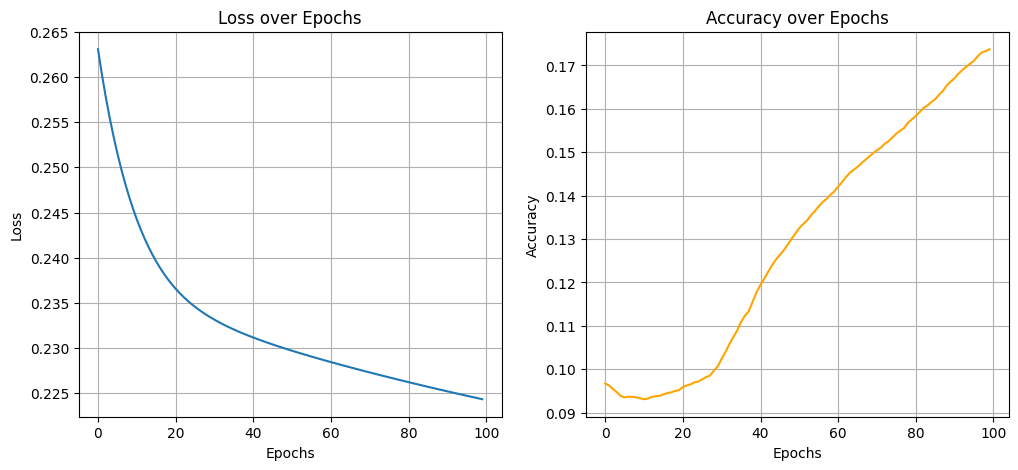

In [9]:
import matplotlib.pyplot as plt
# Function to plot loss and accuracy
def plot_metrics(nn):
    epochs = len(nn.loss_history)
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), nn.loss_history, label="Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), nn.accuracy_history, label="Accuracy", color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.grid(True)

    plt.show()

# Visualize the training process
plot_metrics(nn)
